In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sm

In [205]:
class Matrix():
    '''
    большой массив с начальными данными по всем трём периодам
    '''
    def __init__(self, FilePath):
        with open(FilePath) as genoms_file:
            genoms = genoms_file.read()
        NASdict = {}
        NamesAndSequence = genoms.split('>')
        for NameAndSeq in NamesAndSequence[1:]:
            start = NameAndSeq.find('\n')
            NASdict[f'{NameAndSeq[:start]}'] = list(NameAndSeq[start+1:].replace('\n','').upper())
        self.df = pd.DataFrame.from_dict(NASdict, orient='index', 
                            columns=range(1,len(NASdict[f'{NamesAndSequence[-1][:start]}'])+1))

    def Separation(self):
        """
        Разделяет на 3 отдельных объекта
        """
        dict1 = {}
        dict2 = {}
        dict3 = {}
        for name in self.df.index:
            if 'hiv1' in name:
                dict1[name] = self.df.loc[name]
            elif 'hiv2' in name:
                dict2[name] = self.df.loc[name]
            elif 'hiv3' in name:
                dict3[name] = self.df.loc[name]
        df1 = pd.DataFrame.from_dict(dict1, orient='index')
        df2 = pd.DataFrame.from_dict(dict2, orient='index')
        df3 = pd.DataFrame.from_dict(dict3, orient='index')
        m1 = MiniMatrix()
        m1.df = df1
        m2 = MiniMatrix()
        m2.df = df2
        m3 = MiniMatrix()
        m3.df = df3
        return m1, m2, m3

class MiniMatrix():
    def ColumnsCleaning(self, SiteGapsThreshold, SiteMonomorphThreshold):
        DropList = []
        N = self.df.shape[0]
        TN = N*SiteMonomorphThreshold
        sm = self.df.sum().copy()
        for i in self.df.columns:
            if sm[i]<=TN:
                DropList.append(i)
        self.df.drop(DropList, inplace=True, axis=1)
        '''
        Удаляет столбец если в нём слишком много пропусков
        '''
#         for i in self.df.columns:
#             if '-' in self.df.loc[:, i].value_counts():
#                 if self.df.loc[:, i].value_counts()['-']/self.df.shape[0]<=SiteGapsThreshold:
#                     DropList.append(i)
        '''
        Удаляет столбец если в нём меньше чем определённое количество элементов,
        отличных от консенсуса
        '''
#         SiteMonomorphThreshold = 1-SiteMonomorphThreshold
#         for i in self.df.columns:
# #             if len(self.df.loc[:,i].value_counts())>=2:
#             if self.df.loc[:,i].value_counts().max()/self.df.shape[0]<=SiteMonomorphThreshold:
#                 DropList.append(i)
# #             if len(self.df.loc[:,i].value_counts())==1:
# #                 DropList.append(i)
#         DropList = list(set(DropList))
#         self.df.drop(DropList, inplace=True, axis=1)
        
#         for i in self.df.columns:
#             # SiteMonomorphThreshold = 1-SiteMonomorphThreshold
#             if self.df.loc[:,i].value_counts().min()/self.df.shape[0]>=SiteMonomorphThreshold:
#                 DropList.append(i)
#         self.DropList = list(set(DropList))
#         self.df.drop(DropList, inplace=True, axis=1)

    def IndexCleaning(self, SeqGapsThreshold):
        """
        Удаляет последовательность если в ней слишком много пропусков
        """
        DropList = []
        for i in self.df.index:
            if '-' in self.df.loc[i, :].value_counts():
                if self.df.loc[i, :].value_counts()['-']/self.df.shape[1]<=SeqGapsThreshold:
                    DropList.append(i)
#         print(DropList)
        self.df.drop(DropList, inplace=True)

    def Binarization(self):
        """
        Преобразует в двоичный вид. 0 - более распространённый вариант. 1 - мутации
        """
        for i in self.df.columns:
            self.df.loc[self.df[i] == self.df.loc[:,i].value_counts().idxmax(), i] = 0
            self.df.loc[self.df[i] != self.df.loc[:,i].value_counts().idxmax(), i] = 1

In [206]:
class Graphs():
    
    def __init__(self, m1, m2, m3, C=0, SearchIntersection=False):
        

        self.C=C
        
        self.df1 = m1.df
        self.df2 = m2.df
        self.df3 = m3.df
        
#         смотрим пересечения по периодам
        self.set1 = set(self.df1.columns)
        self.set2 = set(self.df2.columns)
        self.set3 = set(self.df3.columns)
        self.set12 = self.set1 & self.set2
        self.set13 = self.set1 & self.set3
        self.set23 = self.set2 & self.set3
        self.set123 = self.set1 & self.set2 & self.set3

        CountDict1 = (self.df1.sum()/(np.shape(self.df1)[0])).loc[list(self.set123)].to_dict()

        CountDict2 = (self.df2.sum()/(np.shape(self.df2)[0])).loc[list(self.set123)].to_dict()
                
        CountDict3 = (self.df3.sum()/(np.shape(self.df3)[0])).loc[list(self.set123)].to_dict()
        self.Dict123 = {1:CountDict1, 2:CountDict2, 3:CountDict3}

        self.Frame123 = pd.DataFrame(self.Dict123)#.loc[list(self.set123)]#.dropna(axis='index')
        self.Frame123 = self.Frame123.loc[list(self.set123)]
        self.Frame123.loc[:,'mean'] = self.Frame123.mean(axis=1)
        
        
        self.new_ids = list(self.Frame123.sort_values('mean', axis=0, ascending=True).index)
        self.SortFrame = self.Frame123.sort_values('mean', axis=0, ascending=True)
        self.logFrame = np.log((1-self.SortFrame)/self.SortFrame)
        
        
        self.SearchIntersection = SearchIntersection
        
        self.x=np.arange(1,len(self.new_ids)+1)
        self.y=(self.logFrame.loc[:,1].to_numpy())
        self.y2=(self.logFrame.loc[:,2].to_numpy())
        self.y3=(self.logFrame.loc[:,3].to_numpy())
        
        self.yDict = dict()
        for n in range(1,4):
            self.yDict[f'y_{n}'] = self.logFrame.loc[:,n].to_numpy()
            
        if self.SearchIntersection:
            x=np.arange(1,100,0.01)
            self.polyDict = dict()
            for n in range(1,4):
                self.polyDict[f'line_{n}']=np.poly1d(np.polyfit(self.x,self.yDict[f'y_{n}'],4))
            absDict=dict()
            ncount=1
            for i in range(1,4):
                for j in range(i+1,4):
                    absDict[f'abs{ncount}']=[]
                    for z in x:
                        absDict[f'abs{ncount}'].append((self.polyDict[f'line_{j}'](z)-self.polyDict[f'line_{i}'](z))**2)
                    ncount+=1
            self.absdf=pd.DataFrame(absDict,index=x)
            self.absdf['sum']=self.absdf.sum(axis=1)
            self.x0=self.absdf[self.absdf['sum']==self.absdf['sum'].min()].index[0]
            self.C=np.mean([self.polyDict[f'line_{n}'](self.x0) for n in range(1,4)])
        self.table_s = self.logFrame.sort_index().T.loc[1:3,:]-self.C

        
#         if self.SearchIntersection:    
#             line_1 = LineString(np.column_stack((self.x, poly(self.x,self.y))))
#             line_2 = LineString(np.column_stack((self.x, poly(self.x,self.y2))))
#             line_3 = LineString(np.column_stack((self.x, poly(self.x,self.y3))))
#             intersection12 = line_1.intersection(line_2)
#             intersection13 = line_1.intersection(line_3)
#             intersection32 = line_3.intersection(line_2)
#             self.x0 = (intersection12.xy[0][0]+intersection13.xy[0][0]+intersection32.xy[0][0])/3
#             self.C = (intersection12.xy[1][0]+intersection13.xy[1][0]+intersection32.xy[1][0])/3
            
#             self.table_poly_s = pd.DataFrame([poly(self.x,self.y),
#                        poly(self.x,self.y2),poly(self.x,self.y3)],
#              columns=self.SortFrame.index, index=range(1,4)).T.sort_index().T-self.C
#             self.table_s = self.logFrame.sort_index().T.loc[1:3,:]-self.C
        
        


    def PrintL(self):
        '''
        Показывает сколько осталось сайтов и сколько пересечений по 
        оставшимся сайтам между периодами
        '''
        texts = ['L1', 'L2', 'L3', 'L12', 'L13', 'L23', 'L123']
        sets = [self.set1, self.set2, self.set3, self.set12, self.set13, self.set23, self.set123]
        for i in range(7):
            print(texts[i],'=',str(len(sets[i])))
            


    def sMeasureLine(self, Mean=False, 
                     axis = 'valueAxis'):
        """
        строит график зависимости beta*s от сайтов
        """
        
        plt.figure(figsize=(6,4), dpi = 200)
        plt.xlabel('$m_i$')
        plt.ylabel('$\\beta(t) \\cdot s_i$')
        '''
        𝑡 = 1—2555 дней с начала заражения, 𝑡 = 2
        — 3285, 𝑡 = 3 —4015
        '''
        
        
        if axis == 'valueAxis':    
            plt.plot(range(1,len([f"{idx}" for idx in self.new_ids])+1), 
                     (self.logFrame.loc[:,1].to_numpy()-self.C),
                     '.-',color='C0',label='t=2555')
            plt.plot(range(1,len([f"{idx}" for idx in self.new_ids])+1), 
                     (self.logFrame.loc[:,2].to_numpy()-self.C),
                     '.-',color='C1',label='t=3285')
            plt.plot(range(1,len([f"{idx}" for idx in self.new_ids])+1), 
                     (self.logFrame.loc[:,3].to_numpy()-self.C),
                     '.-',color='C2',label='t=4015')
            if Mean:
                plt.plot(range(1,len([f"{idx}" for idx in self.new_ids])+1), 
                         (self.logFrame.loc[:,'mean'].to_numpy()-self.C),
                         '.--',color='k',label='mean')
            
        elif axis =='unvalueAxis':
            for n in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.plot(self.x, self.yDict[f'y_{n}']-self.C,'.-',
                         label=f'{self.mat["tsecs"][0][n-1]}',color=f'C{n-1}')
            if Mean:
                plt.plot(self.x,(self.logFrame.loc[:,'mean'].to_numpy()-self.C),
                         '.--',color='k',label='mean')
         
        plt.legend()
        if self.SearchIntersection:
            plt.plot(self.x0,0,'ok')
            ax = plt.gca()
            ax.axhline(y=0, color='k',ls=':')   
    
    def PolyS(self):
        plt.figure(figsize=(6,4), dpi = 200)
        plt.xlabel('$m_i$')
        plt.ylabel('$\\beta(t) \\cdot s_i$')
        for n in range(1,4):
            plt.plot(self.x, self.yDict[f'y_{n}'],'.-',alpha=0.3, 
                     color=f'C{n-1}',label=f't={n}')
            plt.plot(np.linspace(1,max(self.x),50), self.polyDict[f'line_{n}'](np.linspace(1,max(self.x),50)), 
                     color=f'C{n-1}')
        plt.legend()    
        if self.SearchIntersection:
            plt.plot(self.x0,self.C,'ok')

    def sMeasureHist(self, Interpol=False,mean=False):
        """
        Гистограмма значений s для каждого сайта
        """
        if Interpol==False:
            for j in range(1,4):
                plt.figure(figsize=(16,4), dpi=200)
                plt.bar(list(self.logFrame.T.columns), 
                        [i for i in (self.table_s).values[j-1]],
                        bottom=None,label='real')
                plt.grid()
            plt.ylabel('$\\beta(t) \\cdot s_i$')
        else:
            for j in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.figure(figsize=(16,4), dpi=300)
                plt.bar(np.array(self.logFrame.T.columns), 
                        [i for i in (self.table_poly_s).values[j-1]],
                        bottom=None, alpha=0.4, color='green',label='poly')
                plt.bar(list(self.logFrame.T.columns), 
                        [i for i in (self.table_s).values[j-1]],
                        bottom=None, alpha=0.4, color='red',label='real')
                plt.legend()
                plt.ylabel(f'$\\beta({self.mat["tsecs"][0][j-1]}) \\cdot s_i$')
                plt.xlabel('nomber of genomic site')
        if mean:
            plt.figure(figsize=(16,4), dpi=300)
            plt.bar(list(self.logFrame.T.columns),self.meanPolyBeta,
                    bottom=None, alpha=0.4, color='green',label='poly')
            plt.bar(list(self.logFrame.T.columns),self.meanBeta,
                    bottom=None, alpha=0.4, color='red',label='real')
            plt.legend()
            plt.ylabel('$\\beta_{mean} \\cdot s_i$')
            plt.xlabel('nomber of genomic site')

In [207]:
M = Matrix('HIV genoms/hiv_alignB123.fas')

In [208]:
m1,m2,m3 = M.Separation()

In [209]:
for m in [m1,m2,m3]:
    m.IndexCleaning(0.05)
    
    
    m.Binarization()
    m.ColumnsCleaning(0.06,0.06)

In [210]:
m1.df.sum()

9       6
72      9
82      5
88     12
94     14
       ..
766     6
772     2
785     3
792     6
825     3
Length: 78, dtype: object

In [211]:
gr = Graphs(m1,m2,m3, SearchIntersection=False)

In [212]:
gr.set123

{9, 72, 88, 478, 479, 483, 525, 534, 652, 653, 785}

### Patient_A: 	IV Drug User, Typical progressor.

### Patient_C: 	IV Drug User, Typical progressor.

### Patient_B: Partner of E. Linked transmission. Typical progressor.

### Patient_E: Sexual partner of B. Slow progressor.

### Patient_MA: Member of Mass. General Hospital cohort. Samples from month 1 (4.5 yrs postinfection) to > 9 yrs HIV infection. Diagnosed in February 1985 at age 23. Asymptomatic in early 1994 (>9 yrs postinfection).

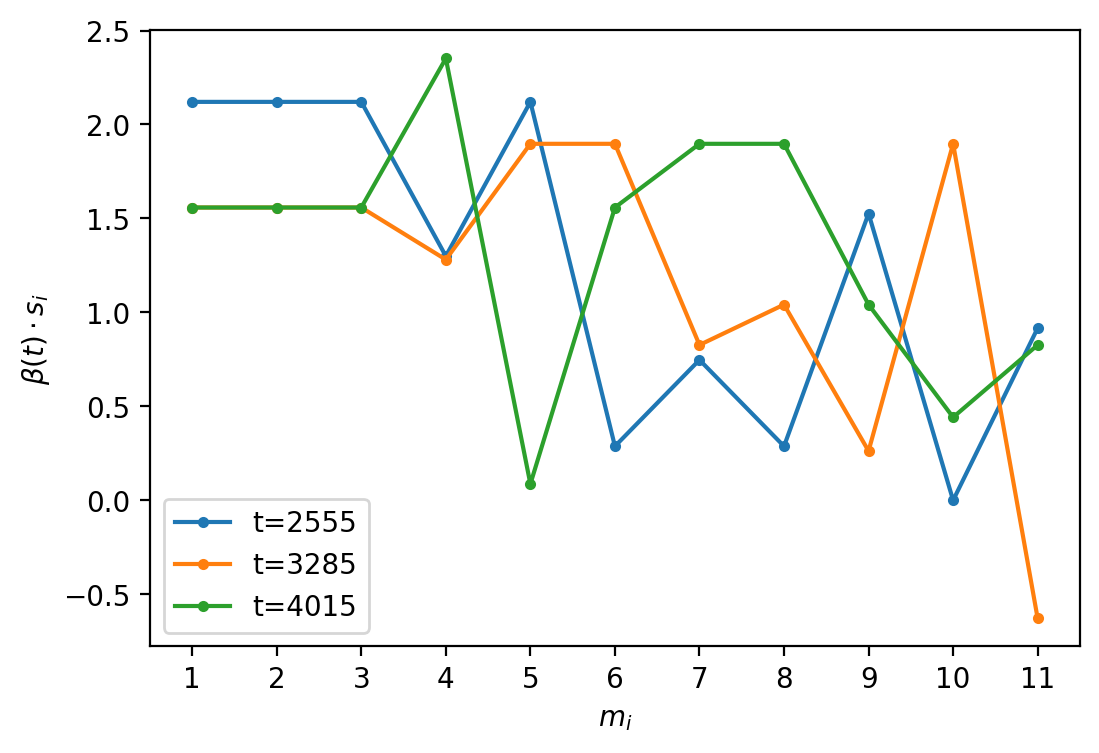

In [213]:
gr.sMeasureLine(Mean=False)
plt.xticks(range(1,len(gr.set123)+1));
# plt.title('Patient MA');

AttributeError: 'Graphs' object has no attribute 'polyDict'

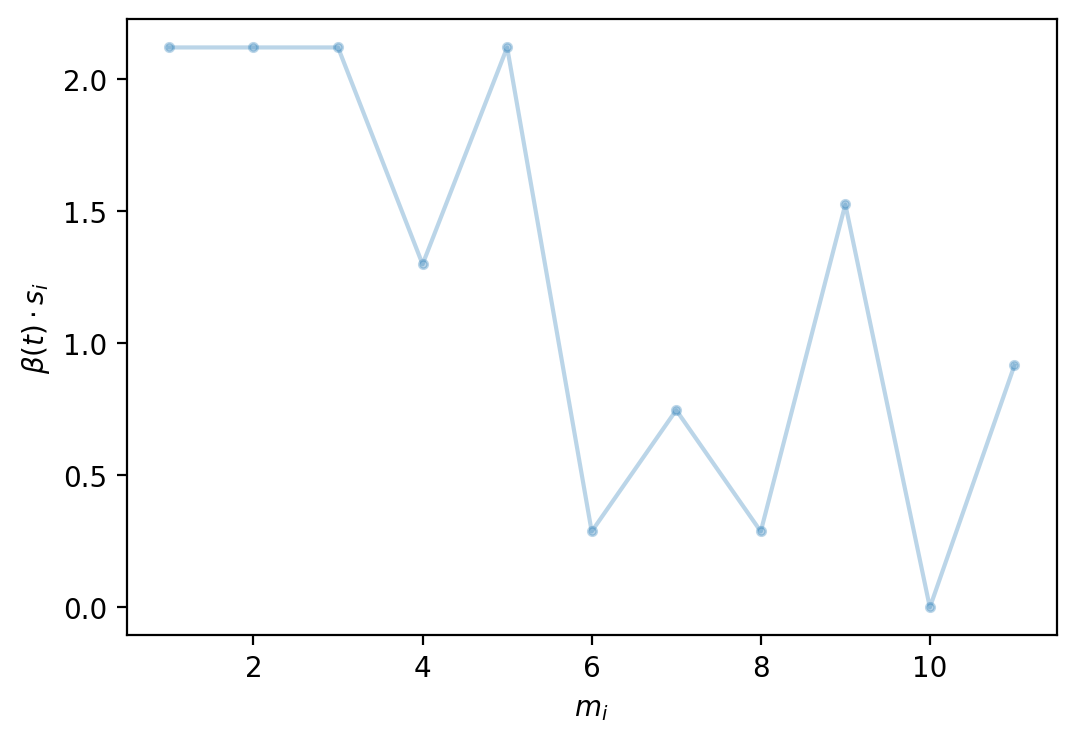

In [214]:
gr.PolyS()
plt.xticks(range(1,len(gr.set123)+1));
# plt.grid();

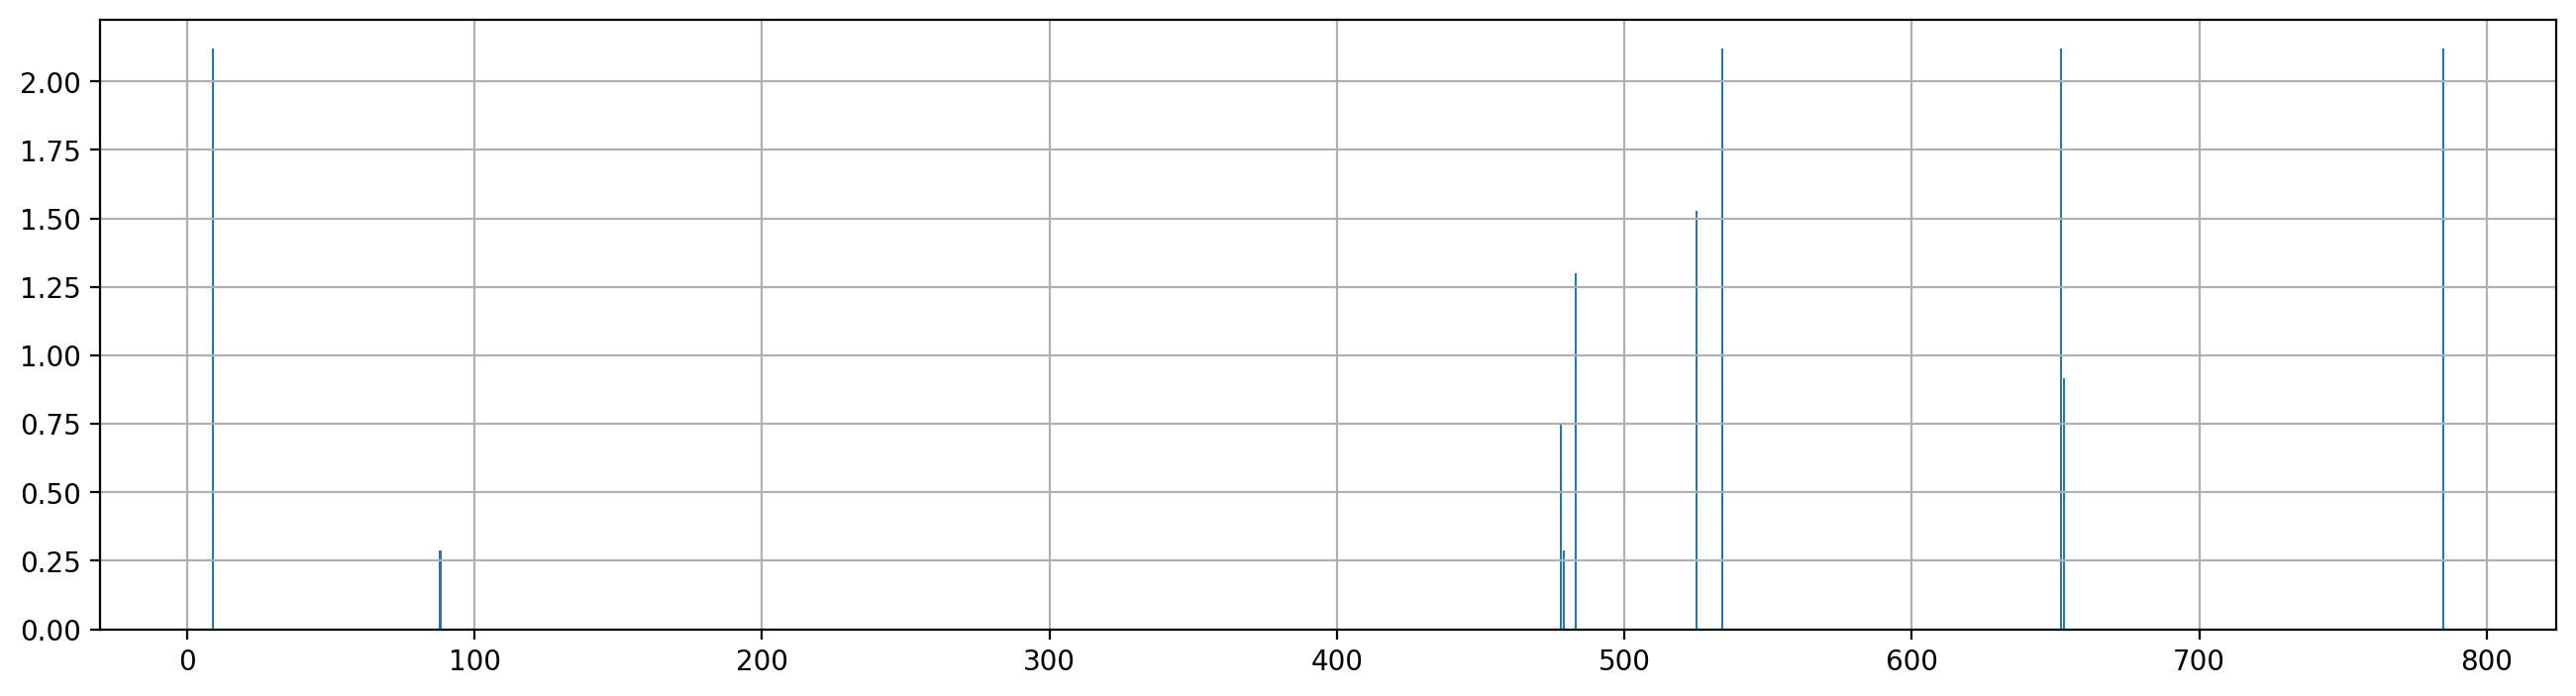

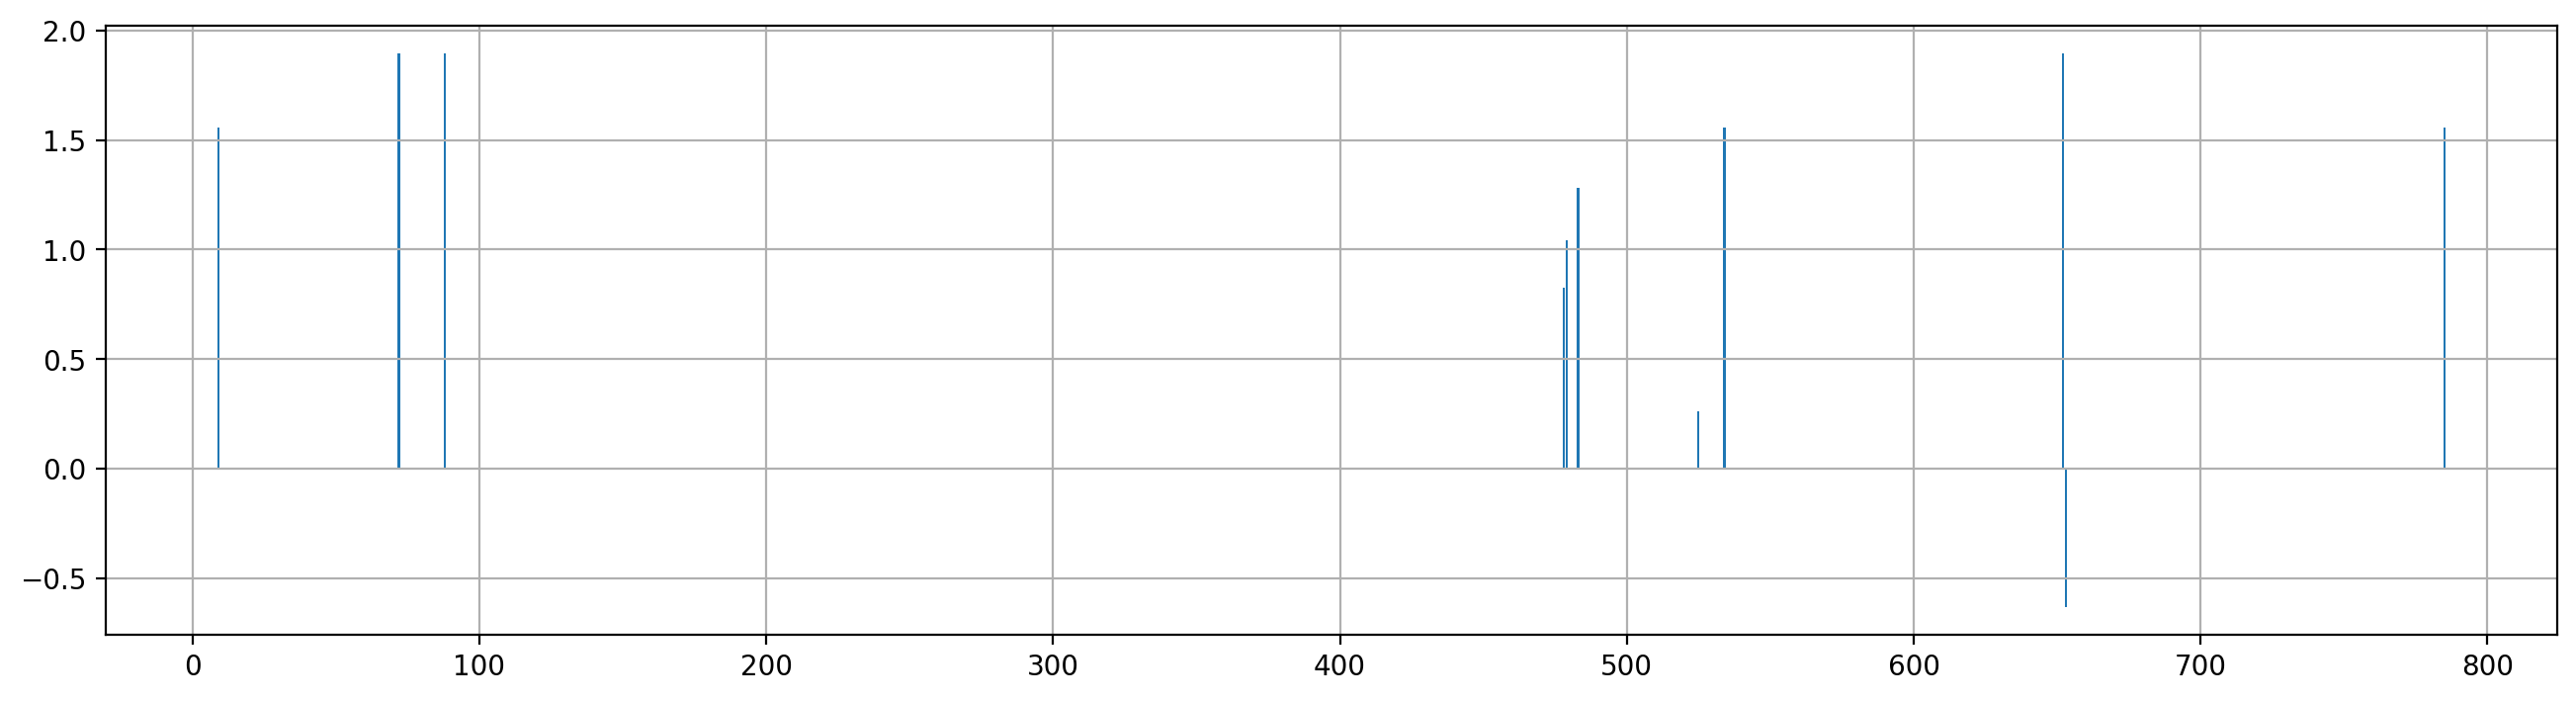

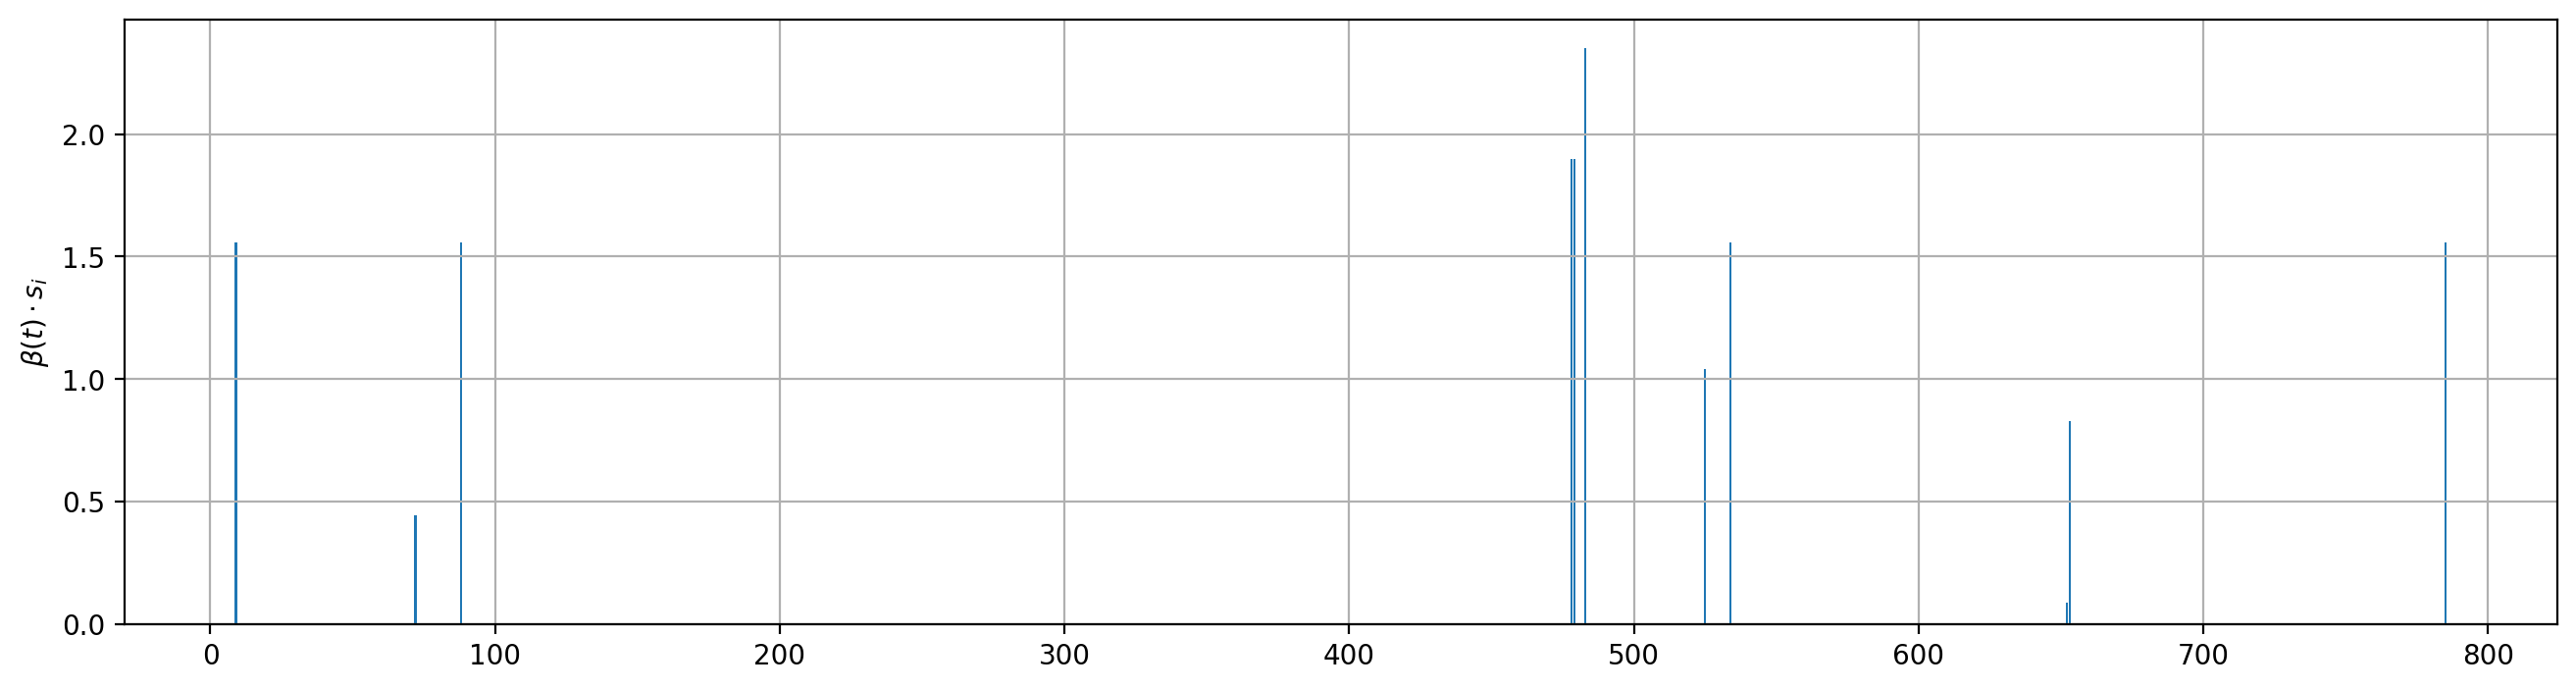

In [215]:
gr.sMeasureHist()

In [216]:
tx = '-0.087,-0.089,-0.081,0.021,-0.079, 0.094,-0.012,-0.031,0.012,0.009,-0.018,-0.016,-0.021,-0.032,-0.039,-0.032,0.252,0.491,0.228,0.028'
txs = tx.split(',')
numlist = []
for i in txs:
    numlist.append(float(i))

In [217]:
len(numlist)

20

Text(0, 0.5, 'D')

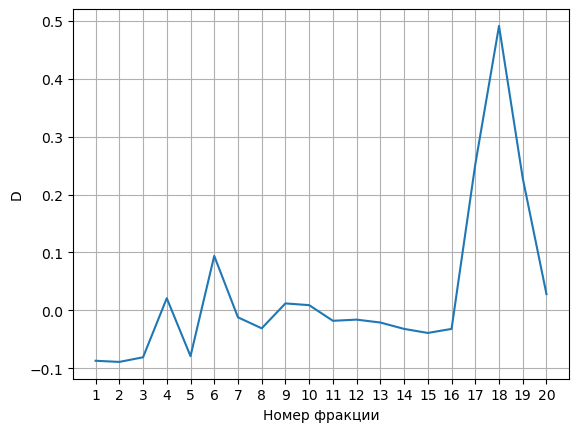

In [218]:
plt.plot(range(1,21),numlist)
plt.grid()
plt.xticks(range(1,21));
plt.xlabel('Номер фракции')
plt.ylabel('D')

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ara1_1 = pd.read_csv('C:/Users/sPIDERman/Desktop/Файлы для гранта/ara_f_1000c.csv')
ara1_2 = pd.read_csv('C:/Users/sPIDERman/Desktop/Файлы для гранта/ara_f_1500c.csv')
ara1_3 = pd.read_csv('C:/Users/sPIDERman/Desktop/Файлы для гранта/ara_f_2000c.csv')
gens = [1000, 1500, 2000]


# print(ara1_1.loc[:,['Minimum', 'Change', 'Variant Frequency', 'Polymorphism Type']].sort_values('Variant Frequency'))
# print(ara1_1.columns)


def convert_percentage(x):
    try:
        return float(x.replace('%', '')) / 100
    except (AttributeError, ValueError, TypeError):
        return None


ara1_1['Variant Frequency'] = ara1_1['Variant Frequency'].apply(convert_percentage)
ara1_1 = ara1_1.dropna(subset=['Variant Frequency'])
ara1_2['Variant Frequency'] = ara1_2['Variant Frequency'].apply(convert_percentage)
ara1_2 = ara1_2.dropna(subset=['Variant Frequency'])
ara1_3['Variant Frequency'] = ara1_3['Variant Frequency'].apply(convert_percentage)
ara1_3 = ara1_3.dropna(subset=['Variant Frequency'])

for ara in [ara1_1, ara1_2, ara1_3]:
    ara.drop(ara[ara["Variant Frequency"] >= 0.95].index, inplace=True)
    ara.drop(ara[ara["Variant Frequency"] <= 0.05].index, inplace=True)
# #
# for i, val in enumerate([ara1_1, ara1_2, ara1_3]):
#     val[f'beta_s_a_{i + 1}'] = (val['Variant Frequency'])
# # print(beta_s)
# common_n_a = ara1_1.merge(ara1_2, on='Minimum').merge(ara1_3, on='Minimum')['Minimum'].sort_values(
#     ascending=True).to_list()
# beta_s_a = ara1_1.merge(ara1_2, on='Minimum').merge(ara1_3,
#                                                     on='Minimum').loc[:, ['Minimum',
#                                                                           'beta_s_a_1', 'beta_s_a_2', 'beta_s_a_3']]
# beta_s_a.loc[:, 'mean'] = beta_s_a.loc[:, ['beta_s_a_1', 'beta_s_a_2', 'beta_s_a_3']].mean(axis=1)
# beta_s_a.sort_values('mean', ascending=False, inplace=True)
# plt.plot(range(len(common_n_a)), beta_s_a['beta_s_a_1'], label='1000')
# plt.plot(range(len(common_n_a)), beta_s_a['beta_s_a_2'], label='1500')
# plt.plot(range(len(common_n_a)), beta_s_a['beta_s_a_3'], label='2000')
# # plt.plot(range(len(common_n)), beta_s['mean'], label='mean', color='k')
# # plt.title('???')
# plt.ylabel('Variant Frequency')
# plt.xlabel('$m_i$')
# plt.title('Variant Frequency in ara_1')
# plt.legend()
# plt.grid()
# plt.show()
#
# # print(ara1_1.sort_values('Variant Frequency'))
# # plt.plot(range(len(ara1_3)),ara1_3.sort_values('Variant Frequency')['Variant Frequency'])
# # plt.ylabel('Variant Frequency')
# # plt.xlabel('$m_i$')
# # plt.title('Variant Frequency in ara_1_1500')
# # plt.grid()
# # plt.show()
# # x1 = range(len(ara1_1))
# # x2 = range(len(ara1_2))
# # x3 = range(len(ara1_3))
# # print(x1, x2, x3)

'''
вот тут были попытки сделать всё миноритарным типа. пока не вышло((
'''
# common_n = ara1_1.merge(ara1_2, on='Minimum').merge(ara1_3, on='Minimum')['Minimum'].sort_values(
#     ascending=True).to_list()
# d_pd_vf = {}
# for i, val in enumerate([ara1_1, ara1_2, ara1_3]):
#     l_num = val['Minimum'].to_list()
#     l_vf = val['Variant Frequency'].to_list()
#     d_pd_vf[i] = dict(zip(l_num, l_vf))
# # print(d_pd_vf[1][393])
#
# # print(pd_vf)
# dtest = {1: dict(), 2: dict(), 3: dict()}
# for i in range(3):
#     for num in d_pd_vf[i]:
#         dtest[i][num] = d_pd_vf[i][num]

# dt = pd.DataFrame(dtest).dropna()
# print(dt)
'''
вот до сюда
'''

'''
это два варианта того как мы считаем бету. Пока они одинаковые)
'''
# for i, val in enumerate([ara1_1, ara1_2, ara1_3]):
#     val[f'beta_s_{i + 1}'] = np.log(val['Variant Frequency'] / (1 - val['Variant Frequency']))
# # print(beta_s)
# common_n = ara1_1.merge(ara1_2, on='Minimum').merge(ara1_3, on='Minimum')['Minimum'].sort_values(
#     ascending=True).to_list()
# beta_s = ara1_1.merge(ara1_2, on='Minimum').merge(ara1_3,
#                                                   on='Minimum').loc[:, ['Minimum',
#                                                                         'beta_s_1', 'beta_s_2', 'beta_s_3']]
# beta_s.loc[:, 'mean'] = beta_s.loc[:, ['beta_s_1', 'beta_s_2', 'beta_s_3']].mean(axis=1)
# beta_s.sort_values('mean', ascending=False, inplace=True)

for i, val in enumerate([ara1_1, ara1_2, ara1_3]):
    val[f'beta_s_{i + 1}'] = np.log(val['Variant Frequency'] / (1 - val['Variant Frequency']))
# print(beta_s)
common_n = ara1_1.merge(ara1_2, on='Minimum').merge(ara1_3, on='Minimum')['Minimum'].sort_values(
    ascending=True).to_list()
beta_s = ara1_1.merge(ara1_2, on='Minimum').merge(ara1_3,
                                                  on='Minimum').loc[:, ['Minimum',
                                                                        'beta_s_1', 'beta_s_2', 'beta_s_3']]
beta_s.loc[:, 'mean'] = beta_s.loc[:, ['beta_s_1', 'beta_s_2', 'beta_s_3']].mean(axis=1)
beta_s.sort_values('mean', ascending=False, inplace=True)
fbeta = beta_s.set_index('Minimum',inplace=False)
fbeta.sort_index(inplace=True)
# print(fbeta)

'''
полимеризация
'''
poly_betas = {}
for i in range(1, 4):
    poly_betas[i] = np.poly1d(np.polyfit(range(len(common_n)), beta_s[f'beta_s_{i}'], 4))
# print(len(common_n))
'''
Ищем точку пересечения
'''
# x=np.arange(1,len(common_n),0.01)
# ncount=1
# absDict = {}
# for i in range(1,4):
#     for j in range(i+1,4):
#         absDict[f'abs{ncount}']=[]
#         for z in x:
#             absDict[f'abs{ncount}'].append((poly_betas[j](z)-poly_betas[i](z))**2)
#         ncount+=1
# absdf=pd.DataFrame(absDict,index=x)
# absdf['sum']=absdf.sum(axis=1)
# x0=absdf[absdf['sum']==absdf['sum'].min()].index[0]
# C=np.mean([poly_betas[n](x0) for n in range(1,4)])
x0 = 3309.7500000000027
C = 0.2071424406583716
'''
рисуем графики s ^_^
'''
# for i in range(1, 4):
#     plt.plot(range(len(common_n)), beta_s[f'beta_s_{i}']-C, label=gens[i - 1])
# # plt.plot(range(len(common_n)), beta_s['mean']-C, label='mean', color='k')
# for i in range(1, 4):
#     plt.plot(range(len(common_n)), poly_betas[i](range(len(common_n)))-C, label=f'poly{gens[i - 1]}')
# plt.plot(x0,0,'ok')
# plt.title('ara_f')
# plt.xlabel('$m_i$')
# plt.ylabel(r'$\beta \cdot s_i$')
# plt.legend()
# plt.grid()
# plt.show()

#4646332
"""
рисуем столбчатые диаграммы <3
"""
fbeta = fbeta -C
# plt.subplots(3,1)
# for j in [1, 2, 3]:
#     plt.subplot(3,1,j)
#     plt.bar(fbeta.index, fbeta.loc[:,f'beta_s_{j}'])
#     ax = plt.gca()
#     ax.axhline(y=0, color='k', ls='-')
#     # plt.legend()
#     plt.ylabel(r'$\beta \cdot s_i$')
#     plt.xlabel('genomic site number')
# plt.show()
tof = fbeta.loc[:,['beta_s_1','beta_s_2','beta_s_3']]

In [220]:
# tof.columns = ['gen 1000', 'gen 1500', 'gen 2000']
# tof.to_csv('coeff_s_ecoli.csv')


In [236]:
tof = pd.read_csv('coeff_s_ecoli.csv',index_col='Сайт')
tof.loc[:,'mean'] = tof.mean(1)
# tof.columns = ['gen. 1000','gen. 1500','gen. 2000']

In [242]:
tof = tof.round(2)
tof.sort_values('mean').iloc[:,:3]

,gen. 1000,gen. 1500,gen. 2000
Сайт,,,
3919785,-3.07,-2.76,-2.91
3918337,-3.05,-2.98,-2.56
3919785,-3.07,-2.61,-2.91
3918316,-3.13,-2.76,-2.60
3919793,-2.92,-2.44,-3.07
...,...,...,...
329433,2.72,2.68,2.62
149575,2.72,2.68,2.62
3221058,2.64,2.72,2.70
